In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import json
import ast
from collections import defaultdict
import re
from datetime import datetime, time, timedelta
from time import sleep
import numpy as np
from IPython.display import clear_output

In [ ]:
gdf = gpd.read_file("traffic_data.json")
gdf['traffic_model'] = gdf['traffic_model'].apply(lambda x: dict(eval(re.sub(r"<class '(\w+)'>", r'\1', x))))

In [ ]:
d = gdf.to_dict(orient='records')

In [ ]:
parsed_d = []
for item in d:
    model_pattern = item['traffic_model']['weekly_pattern']
    trimmed_pattern = { k: dict(v) for k, v in model_pattern.items() if v }
    if trimmed_pattern:
        item['traffic_model']['weekly_pattern'] = dict(trimmed_pattern)
        parsed_d.append(item)

In [ ]:
parsed_gdf = gpd.GeoDataFrame(parsed_d)

In [ ]:
parsed_gdf.drop('traffic', axis=1, inplace=True)

In [ ]:
parsed_gdf.to_file('cleaned_traffic_data.json', driver='GeoJSON')

In [ ]:
def min_max_normalize(v, min_val, max_val):
    if min_val == max_val:  # Avoid division by zero
        return 2.5  # Midpoint of 1-5

    normalized = 10 * (v - min_val) / (max_val - min_val)
    return int(normalized)

def log_normalize(v, min_val, max_val, epsilon=1e-6):
    if min_val == max_val:  # Avoid division by zero
        return 3  # Midpoint of 1-5

    log_v = np.log(v + epsilon)
    log_min = np.log(min_val + epsilon)
    log_max = np.log(max_val + epsilon)

    normalized = 5 * (log_v - log_min) / (log_max - log_min)
    return int(max(0, min(5, normalized)))  # Clamp within [1, 5]

In [ ]:
with open('cleaned_traffic_data.json', 'r') as f:
    data = json.load(f)

In [ ]:
traffic_min = 1000000000
traffic_max = 0
for i, feature in enumerate(data['features']):
    traffic_model = ast.literal_eval(feature['properties']['traffic_model'])
    data['features'][i]['properties']['traffic_model'] = traffic_model
    values_list = [value for d in traffic_model['weekly_pattern'].values() for value in d.values()]
    if min(values_list) < traffic_min:
        traffic_min = min(values_list)
    if max(values_list) > traffic_max:
        traffic_max = max(values_list)
print(traffic_min)
print(traffic_max)

In [ ]:
for feature in data['features']:
    pttn = feature['properties']['traffic_model']['weekly_pattern']
    
    for weekday, times in pttn.items():
        for time, value in times.items():
            pttn[weekday][time] = log_normalize(value, traffic_min, traffic_max)


In [ ]:
with open('normalized_cleaned_traffic_data.json', 'w') as f:
    json.dump(data, f)

In [ ]:
with open('normalized_cleaned_traffic_data.json', 'r') as f:
    data = json.load(f)

gdf = gpd.GeoDataFrame.from_features(data["features"])

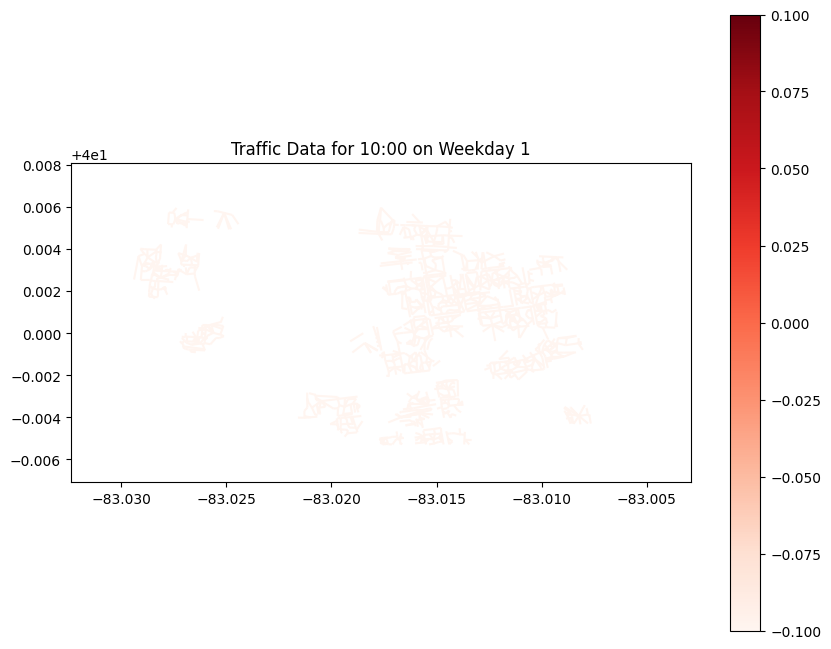

KeyboardInterrupt: 

In [19]:
# Function to extract traffic for a specific time
def extract_traffic(feature, weekday, time):
    weekly_pattern = feature["weekly_pattern"]
    if weekday in weekly_pattern and time in weekly_pattern[str(weekday)]:
        return weekly_pattern.get(str(weekday), {}).get(time, 0)
    return 0

# Select weekday and time (Example: Monday at 09:00)
weekday = 1  # 0 = Sunday, 1 = Monday, etc.

start = datetime(1900, 1, 1, 8, 0)
for i in range(2000):
    time = start.time().strftime('%H:%M')

    # Apply traffic extraction
    gdf["traffic_at_time"] = gdf["traffic_model"].apply(lambda x: extract_traffic(x, weekday, time))

    # Plot the map with traffic data
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    #ax.set_xlim(-83.0127, -83.0193)  # minx, maxx
    #ax.set_ylim(40.0011, 40.0044)  # miny, maxy
    ax.set_xlim(-83.0324, -83.0029)  # minx, maxx
    ax.set_ylim(39.9929, 40.0081)  # miny, maxy
    gdf.plot(column="traffic_at_time", cmap="Reds", legend=True, ax=ax)
    plt.title(f"Traffic Data for {time} on Weekday {weekday}")
    clear_output(True)
    plt.show()
    start = start + timedelta(minutes=5)
    sleep(0.1)

In [17]:
gdf["traffic_model"].iloc[0][weekday]

KeyError: 1

In [ ]:
with open('normalized_cleaned_traffic_data.json', 'r') as f:
    data = json.load(f)

In [ ]:
for i, feat in enumerate(data['features']):
    end = data['features'][i]['properties']['traffic_model']['end_date']
    if isinstance(end, list):
        data['features'][i]['properties']['traffic_model']['end_date'] = end[0]

In [ ]:
with open('normalized_cleaned_traffic_data.json', 'w') as f:
    json.dump(data, f)